In [1]:
import os
from collections import defaultdict
import inspect
import pandas as pd
import numpy as np
from scipy import stats
import re
from graphviz import Digraph
import matplotlib.pyplot as plt
import json
from functools import wraps
import seaborn as sns

import sys
# sys.path.append('/Users/huangbiao/Documents/github/fairInstrumentation')

from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize, KBinsDiscretizer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from utils import *
from fairness_instru import *

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth',1000)
np.set_printoptions(precision = 4)
pd.set_option("display.precision", 4)
pd.set_option('expand_frame_repr', True)

In [4]:
def int_to_string(n):
    return n.to_bytes(math.ceil(n.bit_length() / 8), 'little').decode()

In [5]:
os.chdir(os.getcwd()+'/../..')

#### functions used to generate matplotlib figures

In [6]:
def autolabel(rects, ax, font_size):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height), fontsize = font_size - 3,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [7]:
def matplotlib_histogram(res, title, pos_group, show_pos, suffix='', export_images=False, save_path = ''):
#     colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    title = title.replace('/','')
    primary_key = remove_list_dup([item[0] for item in res.keys()])
    names = remove_list_dup([item[1] for item in res.keys()])
    
    x = np.arange(len(primary_key))
    width = 0.15
    
    ys_pos, ys_neg = [], []
    for value in res.values():
        neg_group = list(value.keys())[1-list(value.keys()).index(pos_group)]
        ys_pos.append(value[pos_group])
        ys_neg.append(value[neg_group])

    ys_pos = np.array(ys_pos).reshape(2, int(len(ys_pos)/2)).T
    ys_neg = np.array(ys_neg).reshape(2, int(len(ys_neg)/2)).T
    
    if show_pos:
        ys = ys_pos
    else:
        ys = ys_neg
    
    fig, ax = plt.subplots(figsize=(10,6), dpi=100)
    
    rects_pos = [ax.bar(x+i*width, y, width, alpha=0.7, edgecolor='white', label=name) for i, (name, y) in enumerate(zip(names, ys))]

#     you can change the font size HERE
    font_size = 18
    
#     pos_group is the input arguments. Negative group will be infered by the function itself.
    if show_pos:
        ax.set_ylabel("annual income "+pos_group, fontsize = font_size)
    else:
        ax.set_ylabel("annual income "+neg_group, fontsize = font_size)
#     ax.set_title(title[:40]+' ...'+suffix if len(title)>40 else title+suffix, fontsize = font_size)
    ax.set_xticks(x+width*((len(ys)-1)/2))
    
    ax.set_xticklabels(primary_key, fontsize = font_size)
    ax.legend(fontsize = font_size - 3)
    plt.grid()
    
    for rect in rects_pos:
        autolabel(rect, ax, font_size)
    
    fig.tight_layout() 
    
#     save to png
    if export_images:
        if not os.path.exists(save_path+"/images"):
            os.mkdir(save_path+"/images")
        if show_pos:    
            plt.savefig(save_path+"/images/"+title+suffix+'_pos.png')
        else:
            plt.savefig(save_path+"/images/"+title+suffix+'_neg.png')
    
    plt.show()
    

#### function used for generate images

In [8]:
def plotly_hist_static_label(pos_group, log_list_dag, plot_dict, suffix='', export_images=False, save_path = ''):
    for status in log_list_dag[:-1]:
        plt_titles='INSPECTING ' + int_to_string(int(status))
        to_plot = sort_dict_key(plot_dict[int(status)])
        print("Positive_Lable:")
        matplotlib_histogram(to_plot, plt_titles, pos_group, show_pos = 1, suffix = suffix, export_images = export_images, save_path = save_path)
        print("Negative_Lable:")
        matplotlib_histogram(to_plot, plt_titles, pos_group, show_pos = 0, suffix = suffix, export_images = export_images, save_path = save_path)

#     plots = create_hist_sub_plot(to_plot[::-1], plt_titles[::-1], pos_group)

#### function used for generate LOG dataframes

In [9]:
def log_static_label(log_list_dag, log_dict, plot_dict):
    plot_log_changes = []
    for status in log_list_dag[:-1]:
        print()
        print('-------------------------------------------------------------------------------------------')
        print(int_to_string(int(status)))
        if int(status) in log_dict.keys():
            temp_table = log_dict[int(status)]
            plot_log_changes.append(pd.DataFrame(sort_dict_key(plot_dict[int(status)])))
            if len(plot_log_changes) == 1:
                print('No changes in STATIC LABEL')
            else:
                if plot_log_changes[-1].equals(plot_log_changes[-2]):
                    print('No changes in STATIC LABEL')
                else:
                    print('Changes in STATIC LABEL, show changes in percentage')
                    display(plot_log_changes[-1] - plot_log_changes[-2])

            for key, dataframe in temp_table.items():
                        # print(plot_log_changes[-1])
                        # print()
                        # print(plot_log_changes[-2])
                        # print()

                # tables_to_display.append(pd.DataFrame(plot_dict[int(status)]).to_html(classes = 'table table-striped'))
                num_cat = "NUMERICAL features" if key == 'num' else "CATEGORICAL features"
                print(" -- TARGET changed in "+num_cat)
                display(dataframe)

        else:
            plot_log_changes.append(pd.DataFrame(sort_dict_key(plot_dict[int(status)])))

            if len(plot_log_changes) == 1:
                print('No changes in STATIC LABEL')
            else:
                if plot_log_changes[-1].equals(plot_log_changes[-2]):
                    print('No changes in STATIC LABEL')
                else:
                    print('Changes in STATIC LABEL, show changes in percentage')
                    display(plot_log_changes[-1] - plot_log_changes[-2])
            print('No changes in population')
    

## 1. Run pipelines here. Attach tracer_pdf decorator

In [10]:
@tracer(cat_col = ['education', 'workclass'], numerical_col = ['age', 'hours-per-week'], 
        sensi_atts=['sex', 'race'], target_name = "income-per-year", training = True, save_path = 'case_outputs/adult_easy')
def adult_pipeline_easy(f_path = 'data/adult_train.csv'):
    
    raw_data = pd.read_csv(f_path, na_values='?', index_col=0)

    data = raw_data.dropna()

    labels = label_binarize(data['income-per-year'], ['>50K', '<=50K'])

    feature_transformation = ColumnTransformer(transformers=[
        ('categorical', OneHotEncoder(handle_unknown='ignore'), ['education', 'workclass']),
        ('numeric', StandardScaler(), ['age', 'hours-per-week'])
    ])


    income_pipeline = Pipeline([
        ('features', feature_transformation),
        ('classifier', DecisionTreeClassifier())])

    return income_pipeline

In [11]:
pipeline = adult_pipeline_easy('data/adult_train.csv')
save_path = 'case_outputs/adult_easy'

AttributeError: module 'scipy.stats' has no attribute 'median_absolute_deviation'

## 2. Now load all saved intermediate status

In [10]:
log_dict_train = pickle.load(open(save_path+"/checkpoints/log_dict_train.p", 'rb'))

rand_rgb_train = pickle.load(open(save_path+"/checkpoints/rand_color_train.p", 'rb'))

plot_dict_train = pickle.load(open(save_path+"/checkpoints/plot_dict_train.p", 'rb'))

log_list_dag_train = pickle.load(open(save_path+"/checkpoints/log_list_dag_train.p", 'rb'))

target_df_train = pickle.load(open(save_path+"/checkpoints/target_df_train.p", 'rb'))

#### Change attrs once dataset changes

In [11]:
snesi_atts = ['sex', 'race']
target_name = 'income-per-year' #adults
pos_group = '>50K'


## 3. Generate Histogram

Positive_Lable:


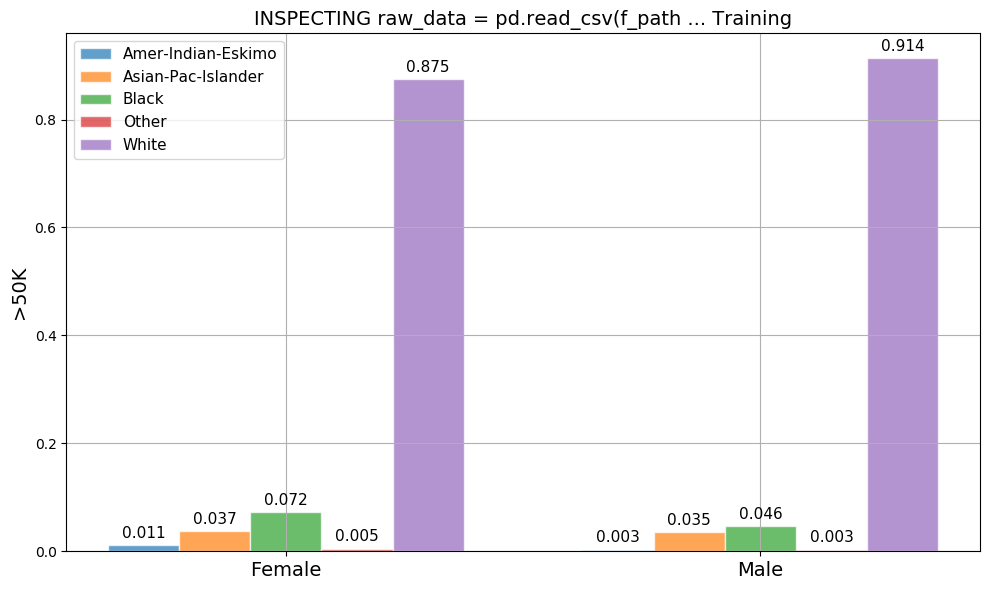

Negative_Lable:


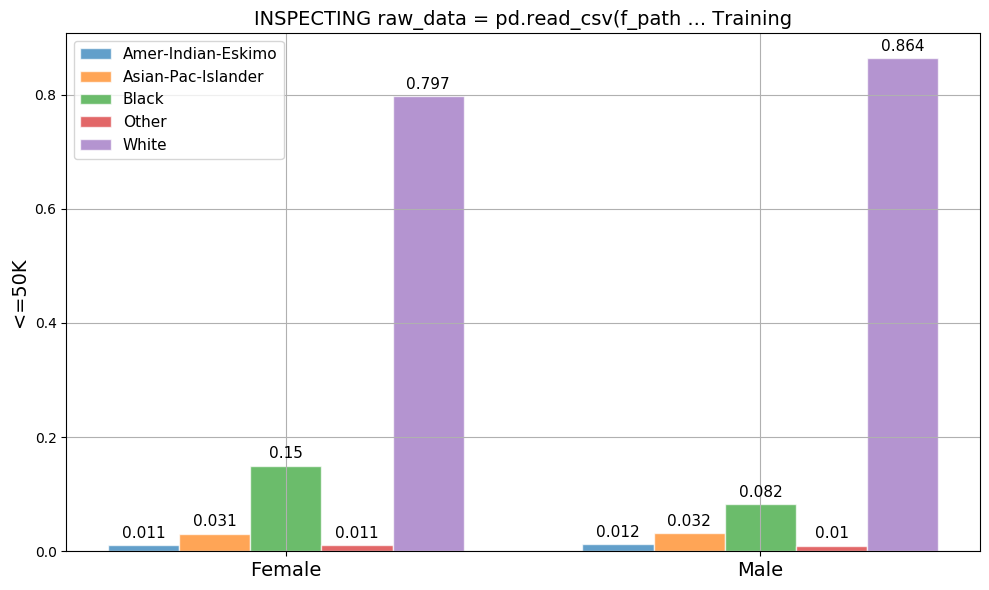

Positive_Lable:


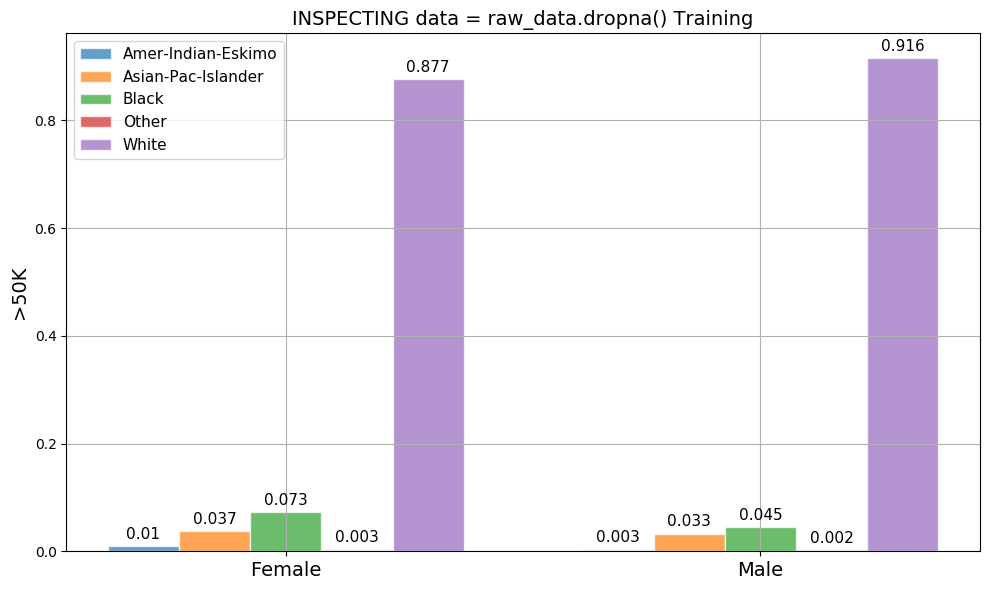

Negative_Lable:


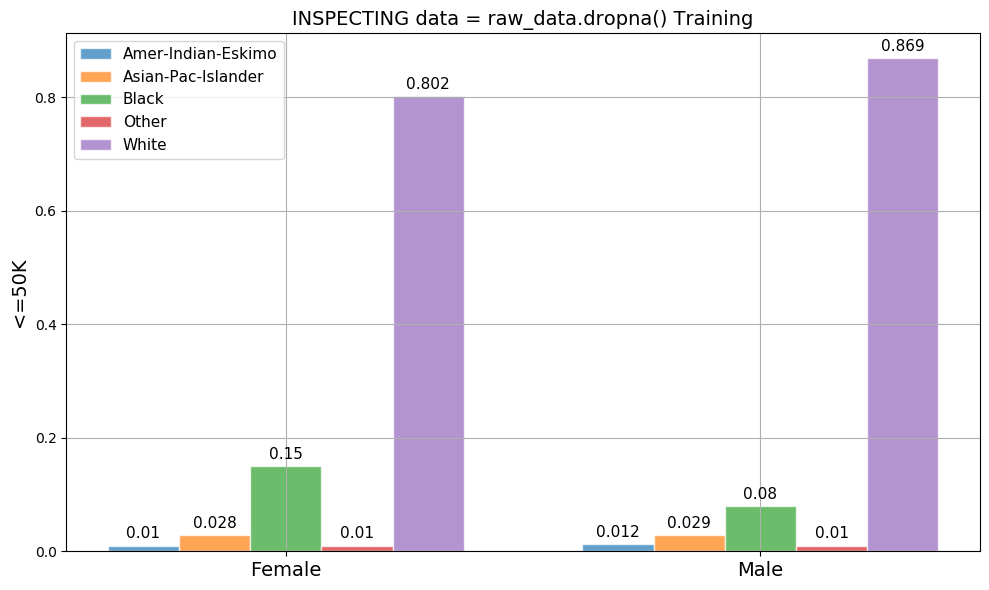

Positive_Lable:


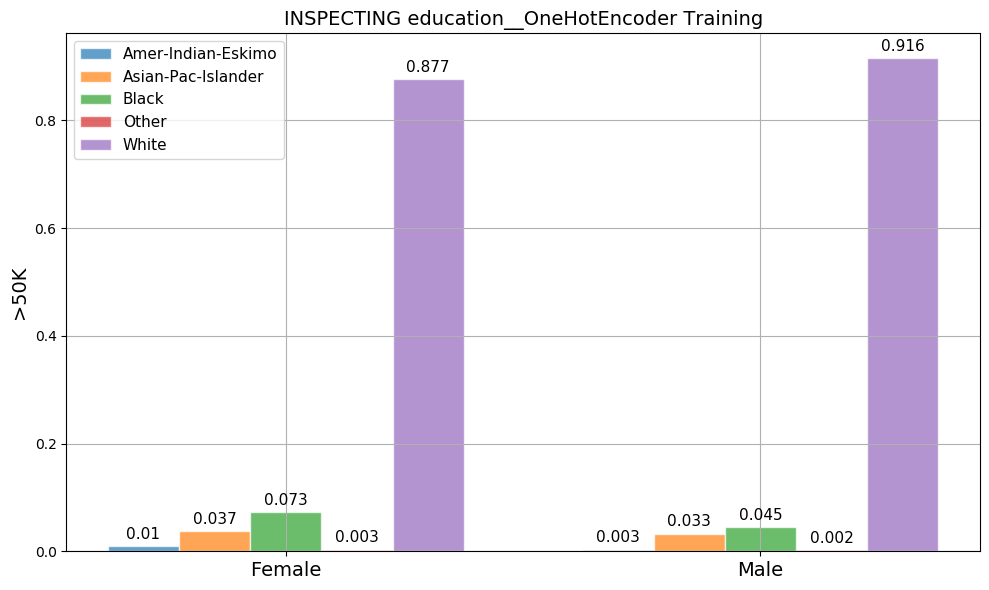

Negative_Lable:


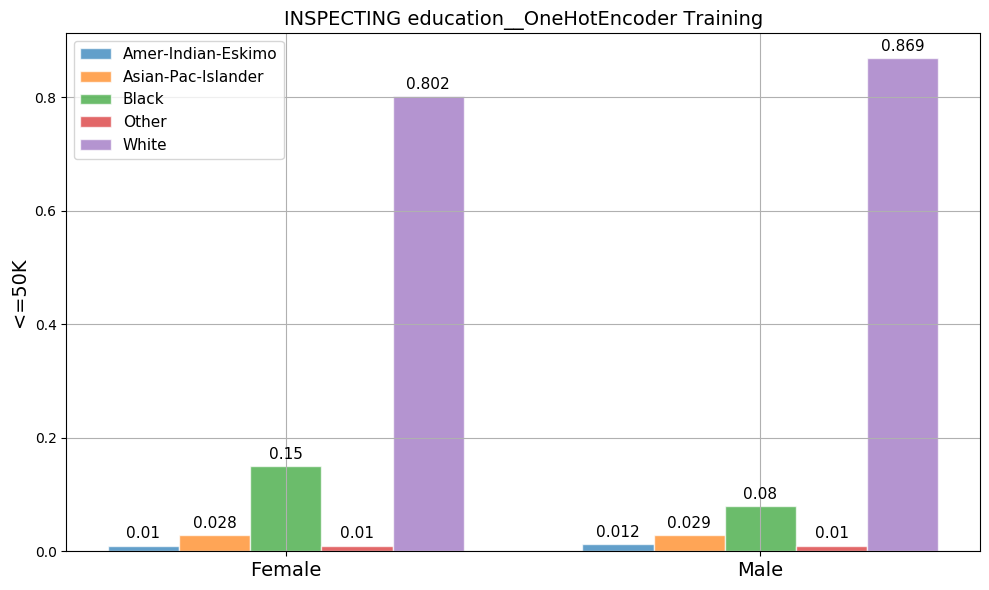

Positive_Lable:


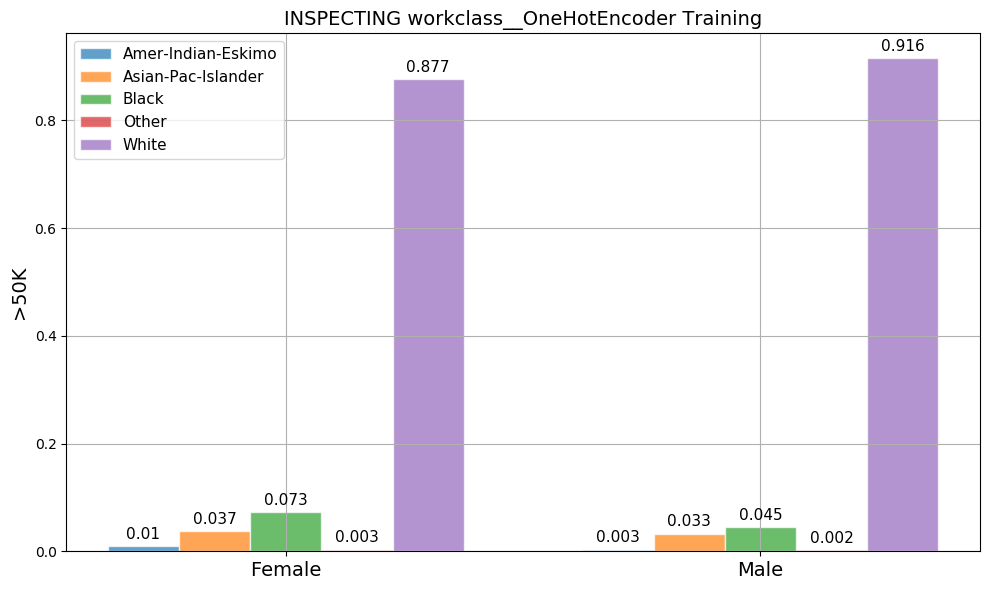

Negative_Lable:


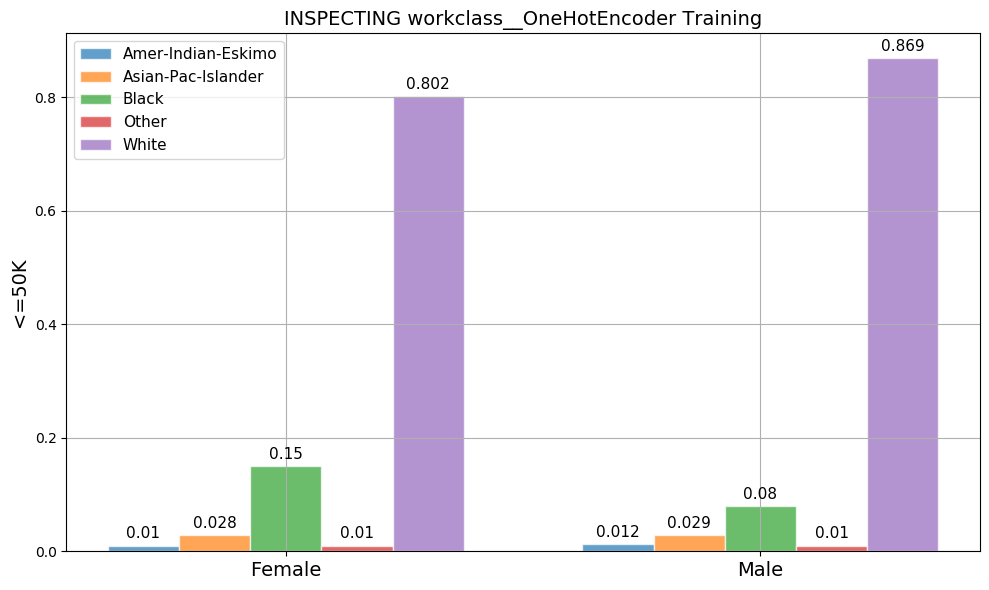

Positive_Lable:


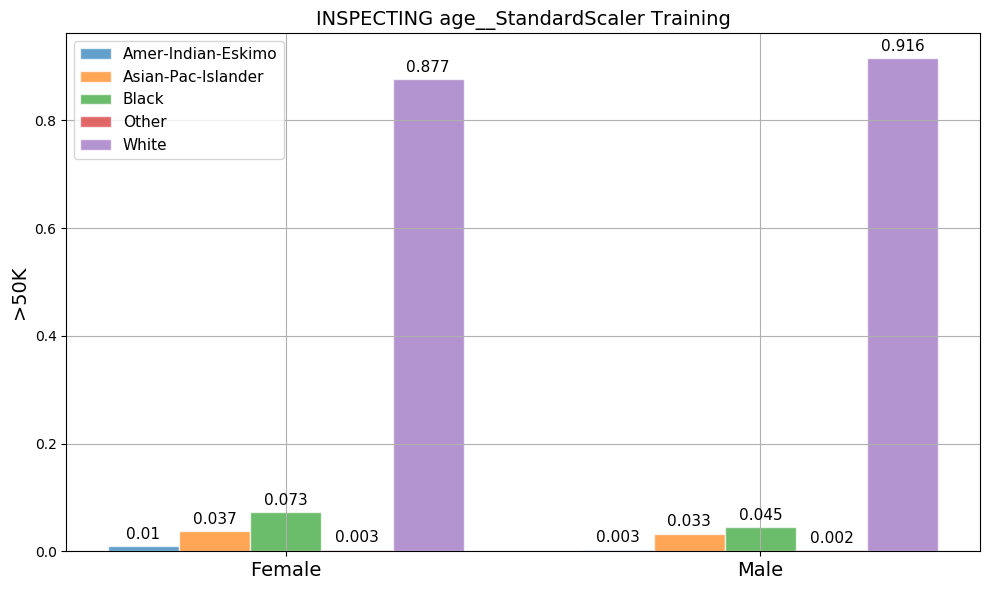

Negative_Lable:


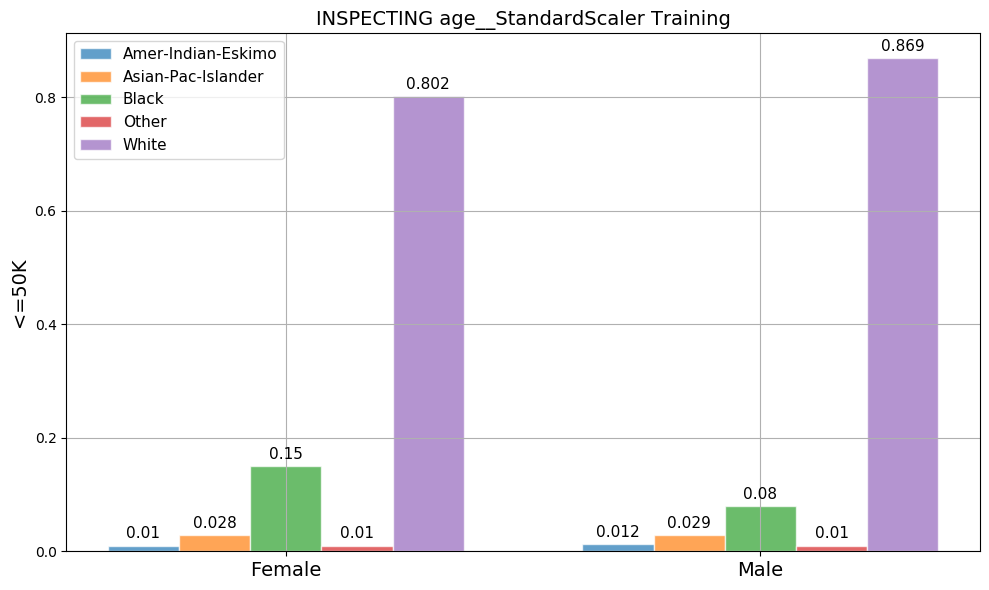

Positive_Lable:


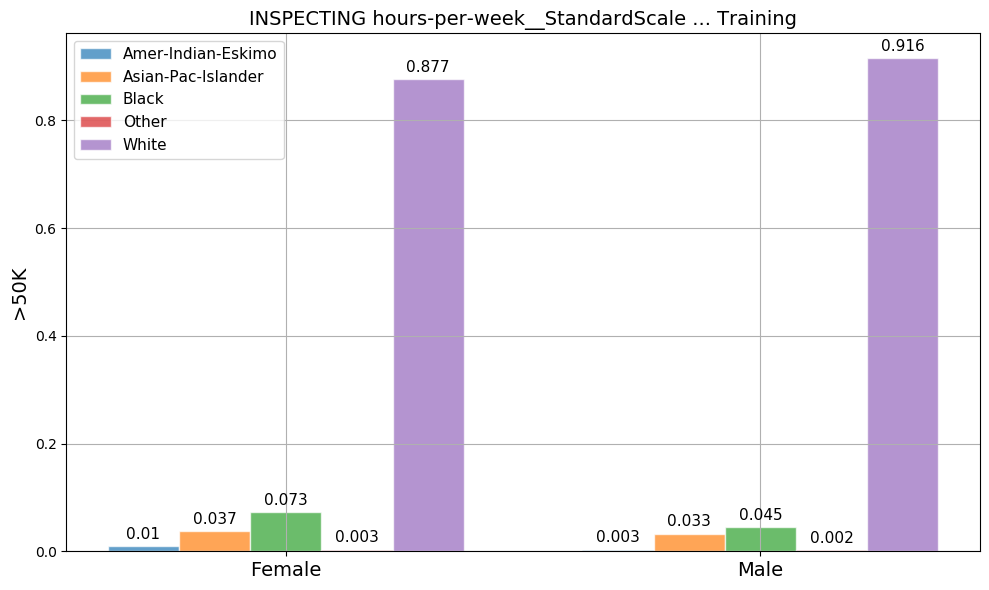

Negative_Lable:


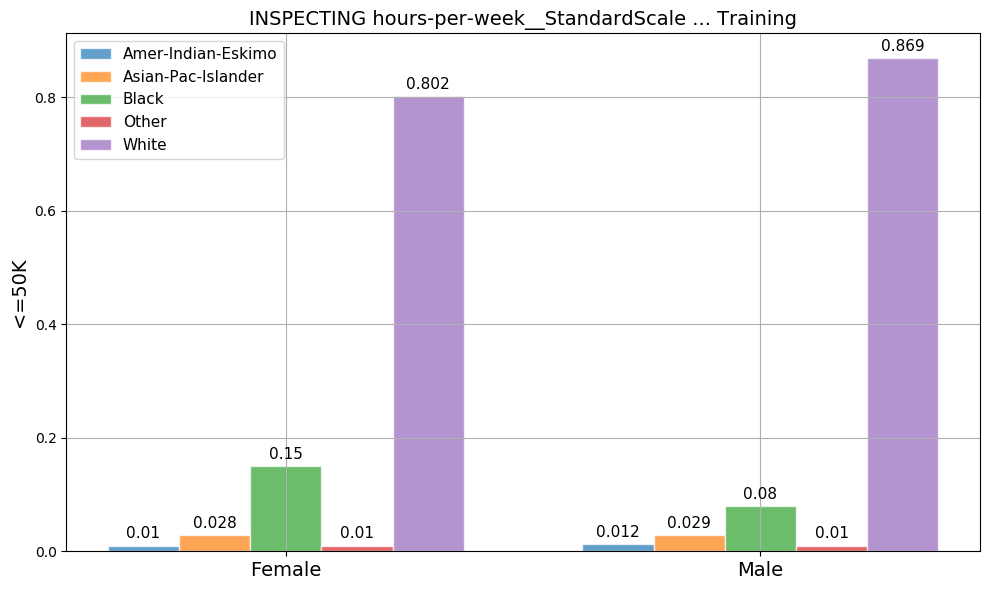

In [12]:
plotly_hist_static_label(pos_group = pos_group, log_list_dag = log_list_dag_train, plot_dict = plot_dict_train, suffix = ' Training', export_images=True, save_path = save_path)


## 4. Generate LOGs

In [13]:
log_static_label(log_list_dag = log_list_dag_train, log_dict = log_dict_train, plot_dict = plot_dict_train)


-------------------------------------------------------------------------------------------
raw_data = pd.read_csv(f_path, na_values='?', index_col=0)
No changes in STATIC LABEL
No changes in population

-------------------------------------------------------------------------------------------
data = raw_data.dropna()
Changes in STATIC LABEL, show changes in percentage


Female                                          \
      Amer-Indian-Eskimo Asian-Pac-Islander  Black  Other  White   
<=50K             -0.001             -0.003  0.000 -0.001  0.005   
>50K              -0.001              0.000  0.001 -0.002  0.002   

                    Male                                          
      Amer-Indian-Eskimo Asian-Pac-Islander  Black  Other  White  
<=50K                0.0             -0.003 -0.002  0.000  0.005  
>50K                 0.0             -0.002 -0.001 -0.001  0.002

 -- TARGET changed in CATEGORICAL features


,missing_count,num_class,class_count,class_percent
education,0.0,0.0,"{'HS-grad': -451, 'Some-college': -433, 'Bachelors': -208, 'Masters': -67, 'Assoc-voc': -43, 'Assoc-acdm': -41, '11th': -78, '10th': -80, 'Prof-school': -23, '7th-8th': -60, '9th': -48, '12th': -41, 'Doctorate': -28, '5th-6th': -29, '1st-4th': -12, 'Preschool': -5}","{'HS-grad': 0.0037, 'Some-college': -0.0029, 'Bachelors': 0.003, 'Masters': 0.001, 'Assoc-voc': 0.0012, 'Assoc-acdm': 0.0007, '11th': -0.001, '10th': -0.0016, 'Prof-school': 0.0003, '7th-8th': -0.0013, '9th': -0.001, '12th': -0.0009, 'Doctorate': -0.0004, '5th-6th': -0.0006, '1st-4th': -0.0001, 'Preschool': -0.0001}"
workclass,-1259.0,-1.0,"{'Private': -277, 'Self-emp-not-inc': -31, 'Local-gov': -19, 'State-gov': -14, 'Self-emp-inc': -31, 'Federal-gov': -12, 'Without-pay': 0}","{'Private': 0.0004, 'Self-emp-not-inc': 0.0, 'Local-gov': 0.0004, 'State-gov': 0.0001, 'Self-emp-inc': -0.0008, 'Federal-gov': 0.0, 'Without-pay': 0.0}"



-------------------------------------------------------------------------------------------
education__OneHotEncoder
No changes in STATIC LABEL
 -- TARGET changed in CATEGORICAL features


,missing_count,num_class,class_count,class_percent
education,0,-14,"{0.0: 20573, 1.0: 572}","{0.0: 0.9729, 1.0: 0.0271}"



-------------------------------------------------------------------------------------------
workclass__OneHotEncoder
No changes in STATIC LABEL
 -- TARGET changed in CATEGORICAL features


,missing_count,num_class,class_count,class_percent
workclass,0,-5,"{0.0: 20484, 1.0: 661}","{0.0: 0.9687, 1.0: 0.0313}"



-------------------------------------------------------------------------------------------
age__StandardScaler
No changes in STATIC LABEL
 -- TARGET changed in NUMERICAL features


,count,missing_count,median,mad,range
age,0.0,0.0,-37.113,-13.6964,-67.4382



-------------------------------------------------------------------------------------------
hours-per-week__StandardScaler
No changes in STATIC LABEL
 -- TARGET changed in NUMERICAL features


,count,missing_count,median,mad,range
hours-per-week,0.0,0.0,-40.0808,-4.0772,-89.8343


## 5. Plot Performance Label and Static Label for Classifier -- Change label inverse once dataset changes

In [14]:
label_inverse = {1: '<=50K', 0:'>50K'}
target_df_train[target_name].replace(label_inverse, inplace = True)
target_df_train['pred_'+target_name].replace(label_inverse, inplace = True)

target_df_train.to_csv(save_path+'/checkpoints/csv/training/prediction.csv')

### Static Label for Input Target Col

Positive_Lable:


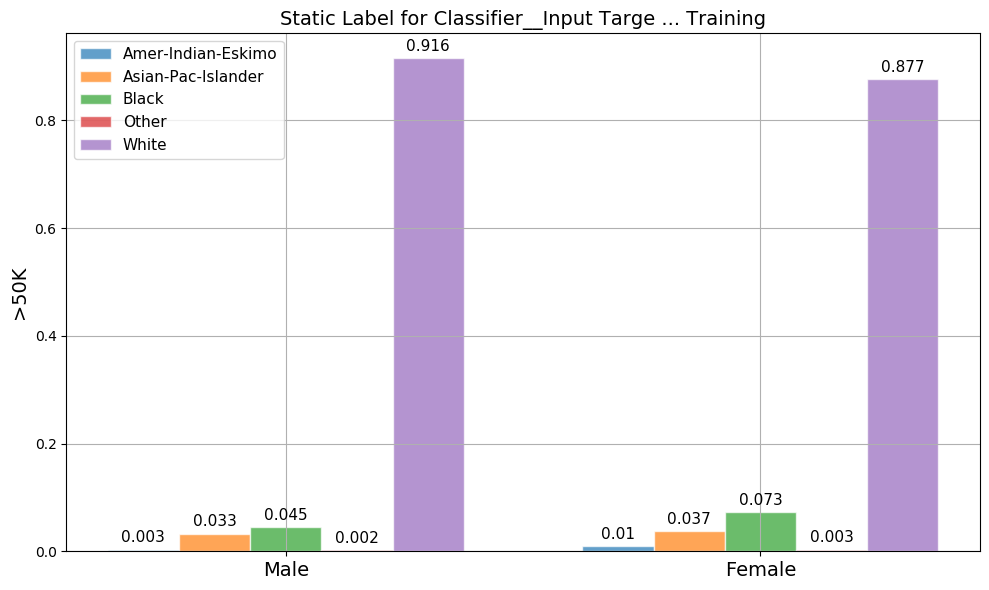

Negative_Lable:


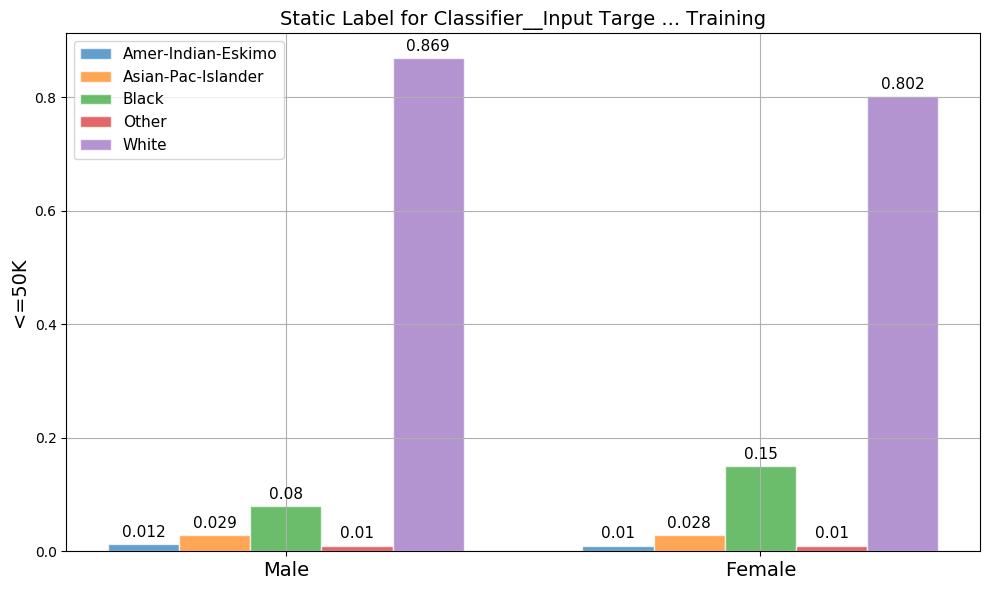

In [15]:
to_plot = static_label(target_df_train, snesi_atts, target_name)
plt_title = 'Static Label for Classifier__Input Target Column'

print("Positive_Lable:")
matplotlib_histogram(to_plot, plt_title, pos_group, show_pos = 1, suffix = ' Training', export_images = True, save_path = save_path)
print("Negative_Lable:")
matplotlib_histogram(to_plot, plt_title, pos_group, show_pos = 0, suffix = ' Training', export_images = True, save_path = save_path)


### Static Label for Predicted Target Col

Positive_Lable:


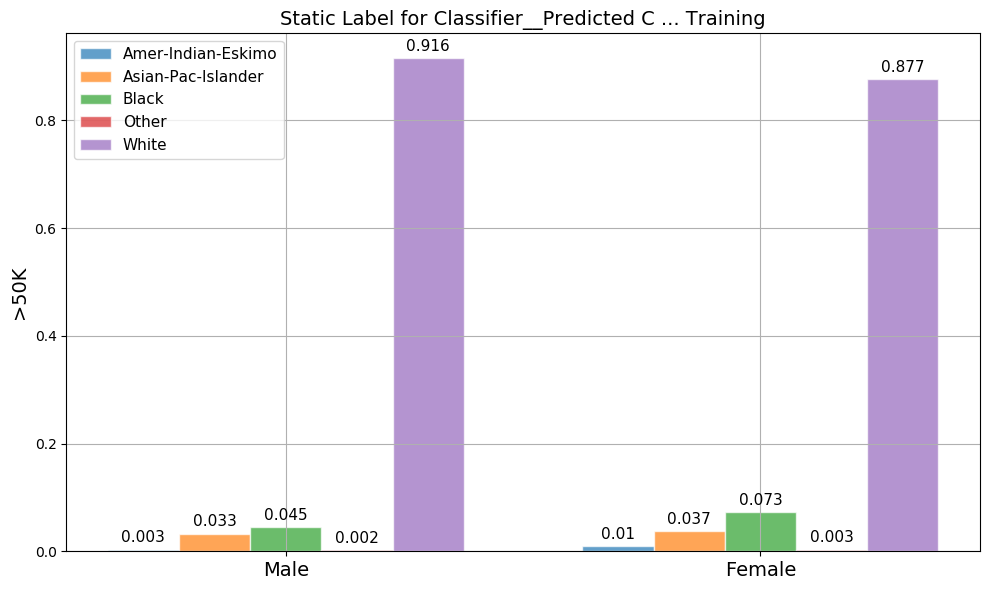

Negative_Lable:


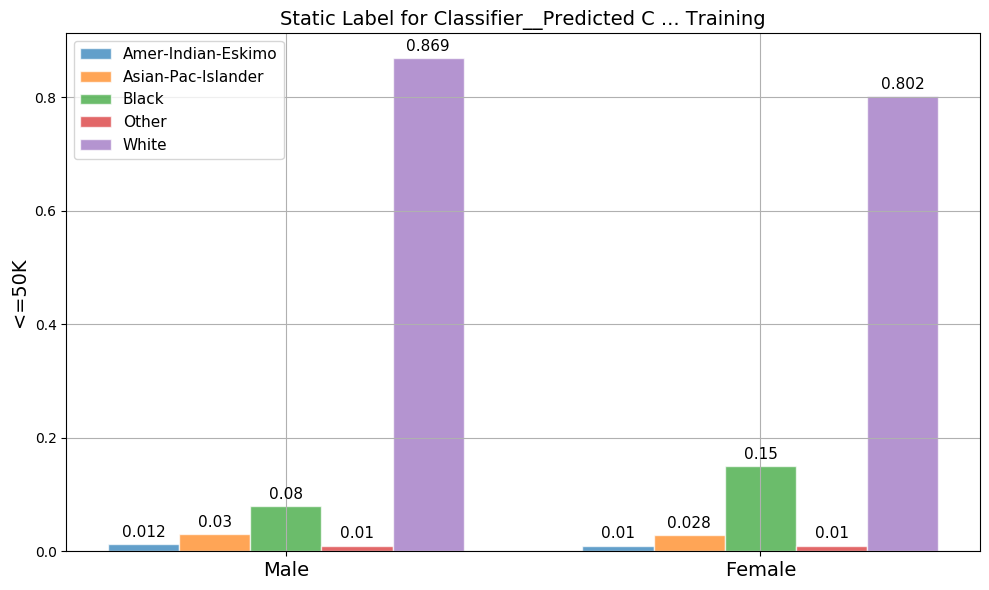

In [16]:
to_plot = static_label(target_df_train, snesi_atts, 'pred_'+target_name)
plt_title = 'Static Label for Classifier__Predicted Column'

print("Positive_Lable:")
matplotlib_histogram(to_plot, plt_title, pos_group, show_pos = 1, suffix = ' Training', export_images = True, save_path = save_path)
print("Negative_Lable:")
matplotlib_histogram(to_plot, plt_title, pos_group, show_pos = 0, suffix = ' Training', export_images = True, save_path = save_path)

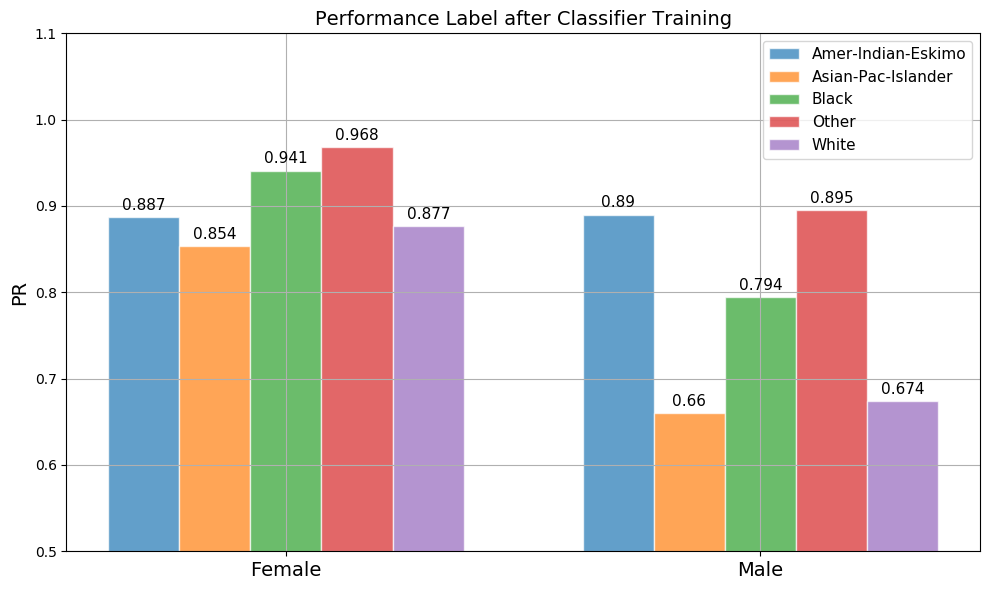

In [17]:
a = get_performance_label(target_df_train, snesi_atts, target_name, pos_group)

draw_bar_plot(a, "PR", snesi_atts, "Performance Label after Classifier Training", False, True, save_path)

# Test Dataset

In [18]:
@tracer(cat_col = ['education', 'workclass'], numerical_col = ['age', 'hours-per-week'], 
        sensi_atts=['sex', 'race'], target_name = "income-per-year", training = False, save_path = 'case_outputs/adult_easy')
def adult_pipeline_easy(f_path = 'data/adult_test.csv'):
    
    raw_data = pd.read_csv(f_path, na_values='?', index_col=0)

    data = raw_data.dropna()

    labels = label_binarize(data['income-per-year'], ['>50K', '<=50K'])

    feature_transformation = ColumnTransformer(transformers=[
        ('categorical', OneHotEncoder(handle_unknown='ignore'), ['education', 'workclass']),
        ('numeric', StandardScaler(), ['age', 'hours-per-week'])
    ])


    income_pipeline = Pipeline([
        ('features', feature_transformation),
        ('classifier', DecisionTreeClassifier())])

    return income_pipeline


In [19]:
pipeline = adult_pipeline_easy('data/adult_test.csv')
save_path = 'case_outputs/adult_easy'

In [20]:
log_dict_test = pickle.load(open(save_path+"/checkpoints/log_dict_test.p", 'rb'))

rand_rgb_test = pickle.load(open(save_path+"/checkpoints/rand_color_test.p", 'rb'))

plot_dict_test = pickle.load(open(save_path+"/checkpoints/plot_dict_test.p", 'rb'))

log_list_dag_test = pickle.load(open(save_path+"/checkpoints/log_list_dag_test.p", 'rb'))

target_df_test = pickle.load(open(save_path+"/checkpoints/target_df_test.p", 'rb'))

clf = pickle.load(open(save_path+"/checkpoints/clf.p", 'rb'))

Positive_Lable:


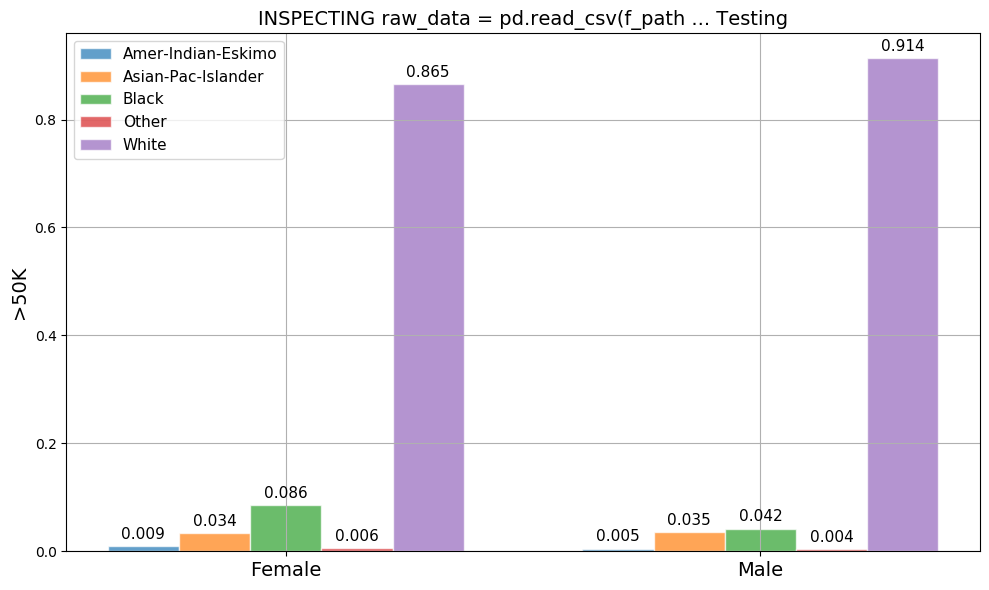

Negative_Lable:


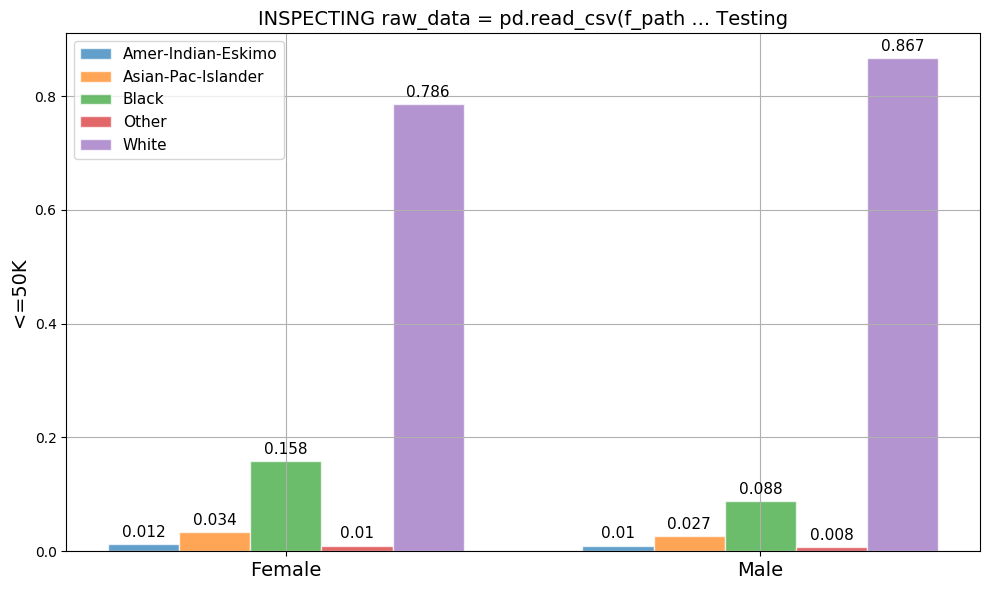

Positive_Lable:


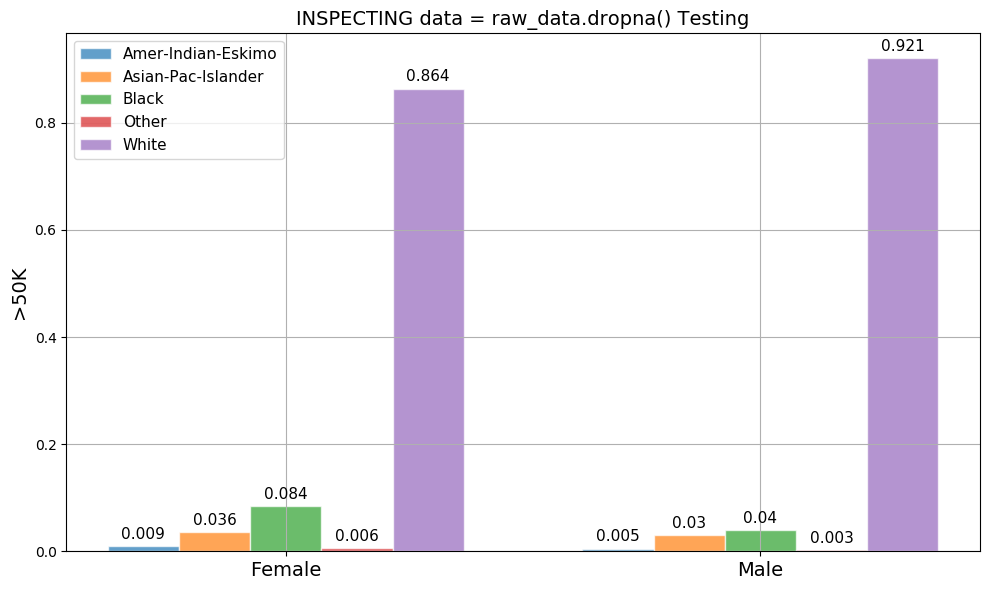

Negative_Lable:


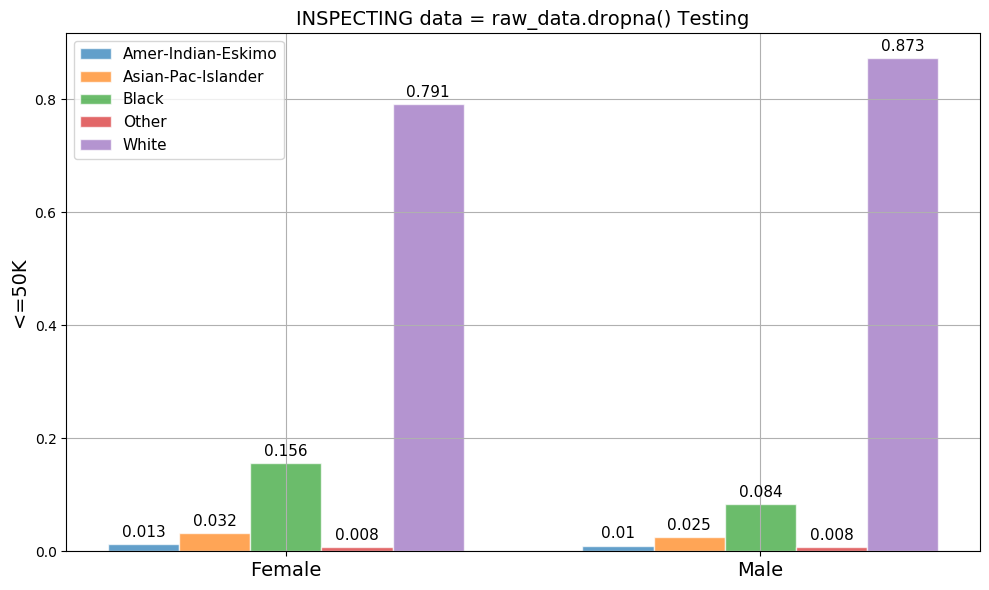

Positive_Lable:


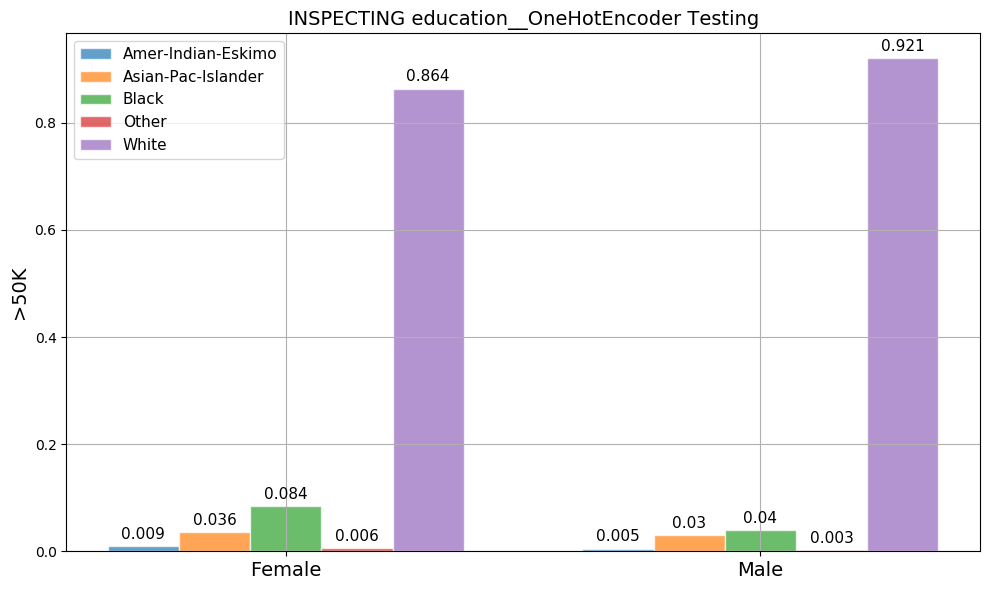

Negative_Lable:


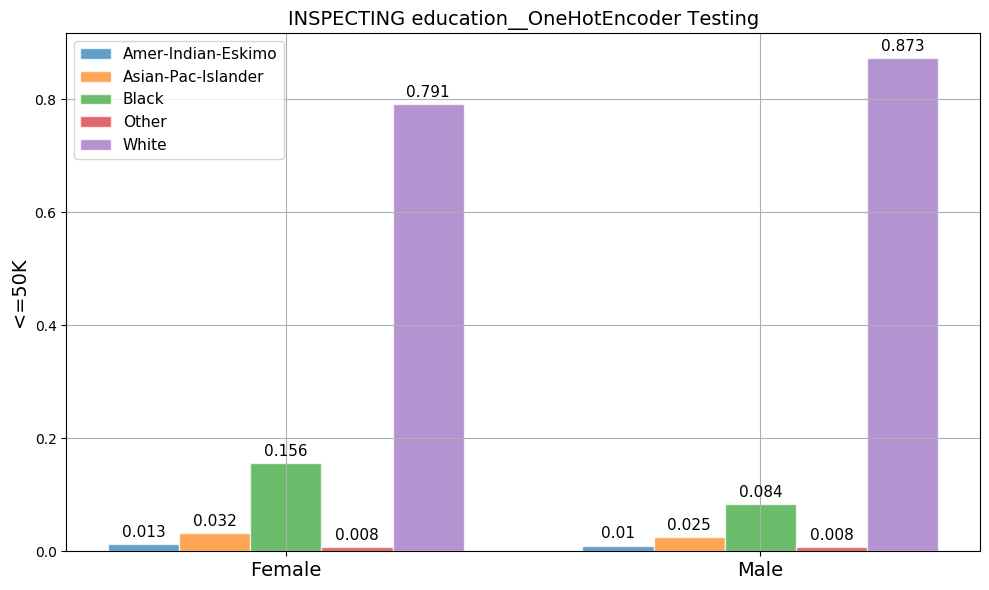

Positive_Lable:


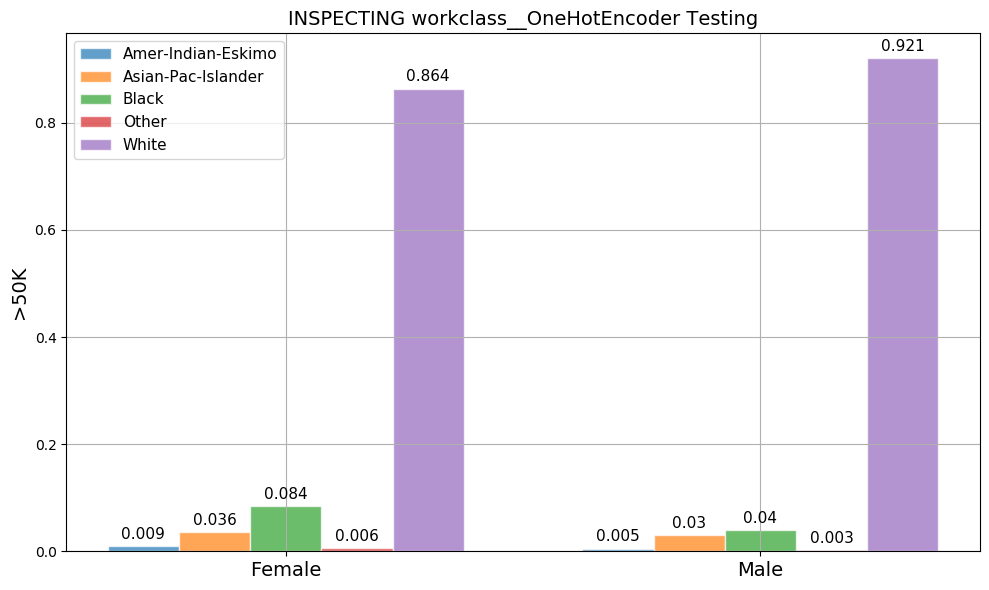

Negative_Lable:


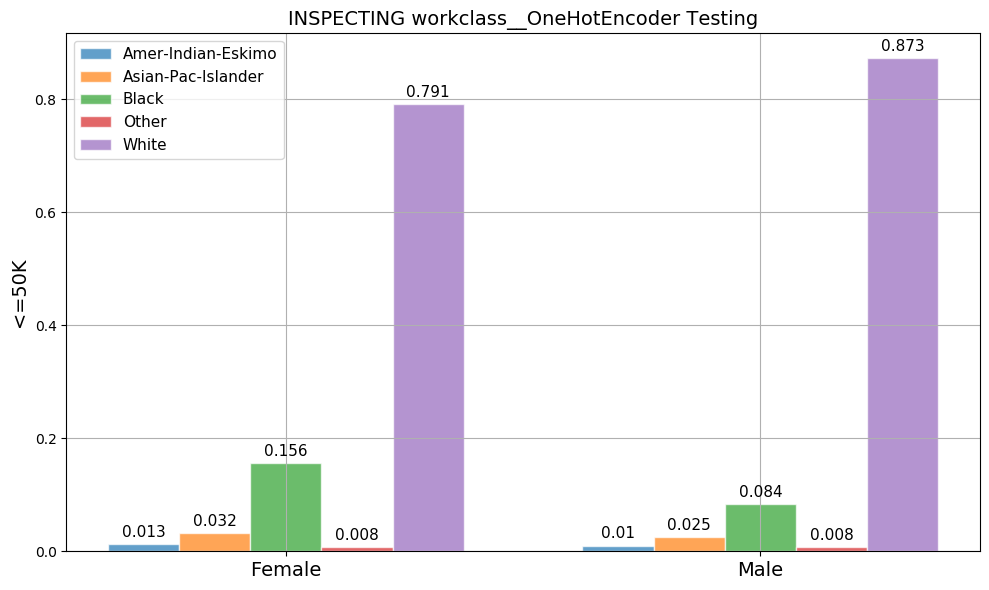

Positive_Lable:


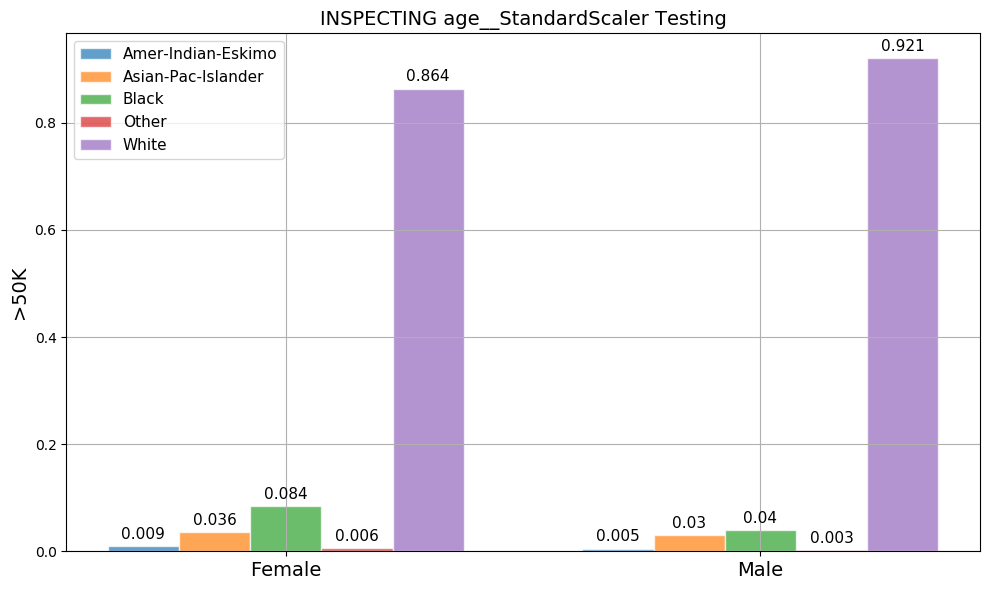

Negative_Lable:


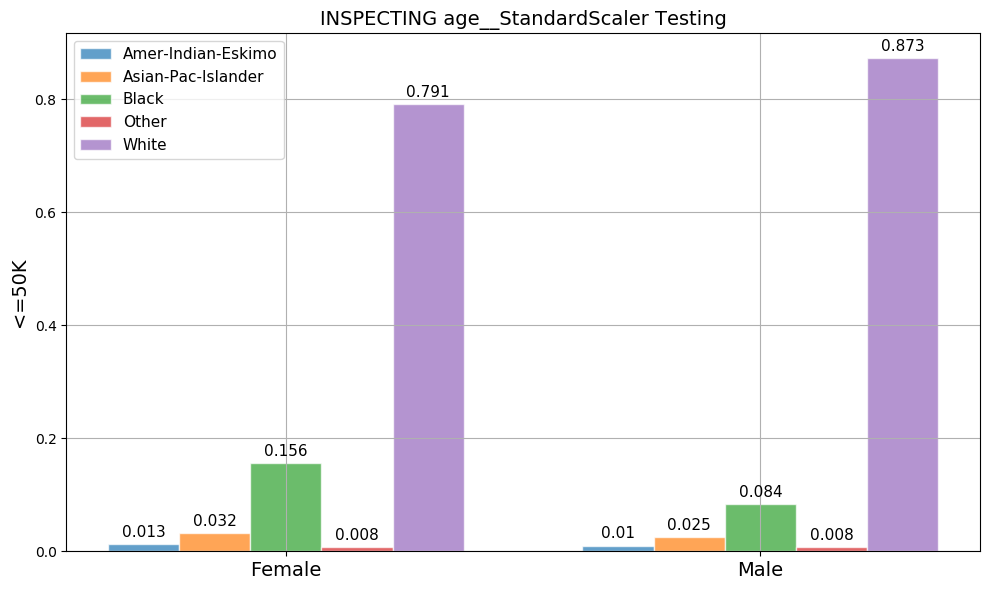

Positive_Lable:


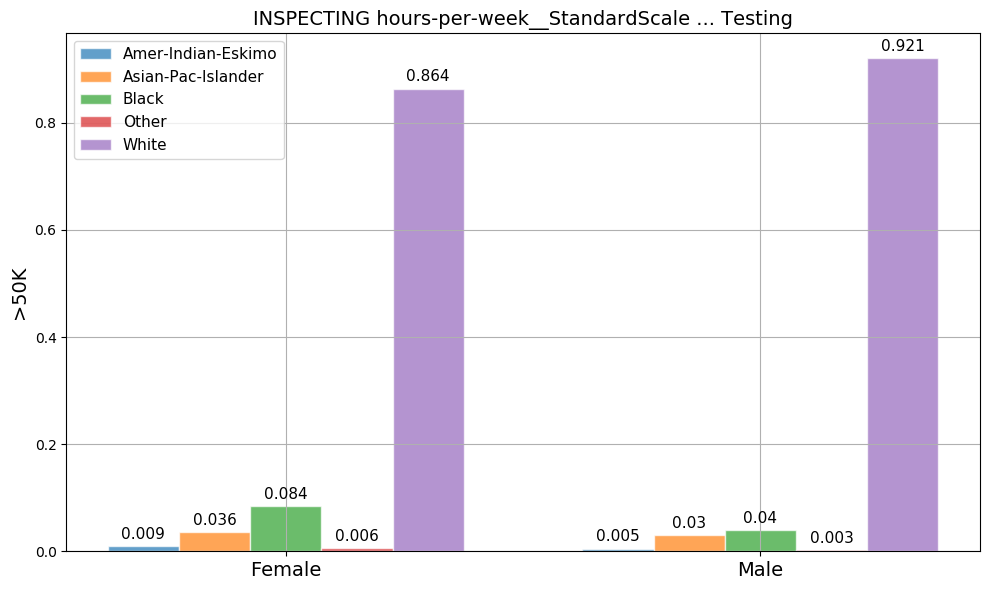

Negative_Lable:


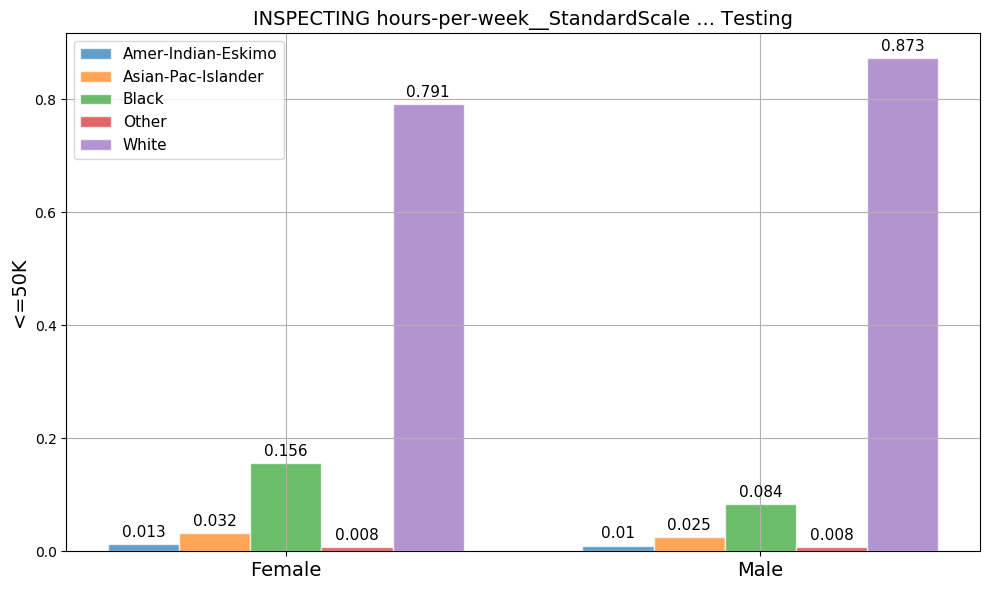

In [21]:
plotly_hist_static_label(pos_group = pos_group, log_list_dag = log_list_dag_test, plot_dict = plot_dict_test, suffix = ' Testing', export_images=True, save_path = save_path)


In [22]:
log_static_label(log_list_dag = log_list_dag_test, log_dict = log_dict_test, plot_dict = plot_dict_test)


-------------------------------------------------------------------------------------------
raw_data = pd.read_csv(f_path, na_values='?', index_col=0)
No changes in STATIC LABEL
No changes in population

-------------------------------------------------------------------------------------------
data = raw_data.dropna()
Changes in STATIC LABEL, show changes in percentage


Female                                          \
      Amer-Indian-Eskimo Asian-Pac-Islander  Black  Other  White   
<=50K              0.001             -0.002 -0.002 -0.002  0.005   
>50K               0.000              0.002 -0.002  0.000 -0.001   

                    Male                                          
      Amer-Indian-Eskimo Asian-Pac-Islander  Black  Other  White  
<=50K                0.0             -0.002 -0.004  0.000  0.006  
>50K                 0.0             -0.005 -0.002 -0.001  0.007

 -- TARGET changed in CATEGORICAL features


,missing_count,num_class,class_count,class_percent
education,0.0,0.0,"{'HS-grad': -210, 'Some-college': -180, 'Bachelors': -103, 'Masters': -29, 'Assoc-voc': -32, '11th': -49, 'Assoc-acdm': -18, '10th': -33, '7th-8th': -29, 'Prof-school': -11, '9th': -11, 'Doctorate': -10, '12th': -15, '5th-6th': -16, '1st-4th': -5, 'Preschool': -1}","{'HS-grad': 0.0038, 'Some-college': -0.0017, 'Bachelors': 0.0023, 'Masters': 0.0011, 'Assoc-voc': 0.0001, '11th': -0.0022, 'Assoc-acdm': 0.0005, '10th': -0.0013, '7th-8th': -0.0015, 'Prof-school': 0.0002, '9th': 0.0001, 'Doctorate': 0.0001, '12th': -0.0005, '5th-6th': -0.0008, '1st-4th': -0.0002, 'Preschool': 0.0001}"
workclass,-577.0,-1.0,"{'Private': -133, 'Self-emp-not-inc': -11, 'Local-gov': -7, 'State-gov': -5, 'Self-emp-inc': -11, 'Federal-gov': -5, 'Without-pay': 0}","{'Private': -0.0004, 'Self-emp-not-inc': 0.0004, 'Local-gov': 0.0005, 'State-gov': 0.0002, 'Self-emp-inc': -0.0005, 'Federal-gov': 0.0001, 'Without-pay': 0.0}"



-------------------------------------------------------------------------------------------
education__OneHotEncoder
No changes in STATIC LABEL
 -- TARGET changed in CATEGORICAL features


,missing_count,num_class,class_count,class_percent
education,0,-14,"{0.0: 8769, 1.0: 248}","{0.0: 0.9725, 1.0: 0.0275}"



-------------------------------------------------------------------------------------------
workclass__OneHotEncoder
No changes in STATIC LABEL
 -- TARGET changed in CATEGORICAL features


,missing_count,num_class,class_count,class_percent
workclass,0,-5,"{0.0: 8735, 1.0: 282}","{0.0: 0.9687, 1.0: 0.0313}"



-------------------------------------------------------------------------------------------
age__StandardScaler
No changes in STATIC LABEL
 -- TARGET changed in NUMERICAL features


,count,missing_count,median,mad,range
age,0.0,0.0,-37.1013,-13.699,-67.451



-------------------------------------------------------------------------------------------
hours-per-week__StandardScaler
No changes in STATIC LABEL
 -- TARGET changed in NUMERICAL features


,count,missing_count,median,mad,range
hours-per-week,0.0,0.0,-40.0706,-2.7166,-89.7843


### Do Training

In [23]:
to_train = target_df_train.drop([target_name], axis=1).select_dtypes(include=['int', 'float64'])
to_test = target_df_test.drop([target_name], axis=1).select_dtypes(include=['int', 'float64'])

clf.fit(to_train, target_df_train[target_name])
target_df_test['pred_'+target_name] = clf.predict(to_test)

### Generate Labels -- Change label inverse once dataset changes

In [24]:
label_inverse = {1: '<=50K', 0:'>50K'}
target_df_test[target_name].replace(label_inverse, inplace = True)
target_df_test['pred_'+target_name].replace(label_inverse, inplace = True)

target_df_test.to_csv(save_path+'/checkpoints/csv/testing/prediction.csv')

Positive_Lable:


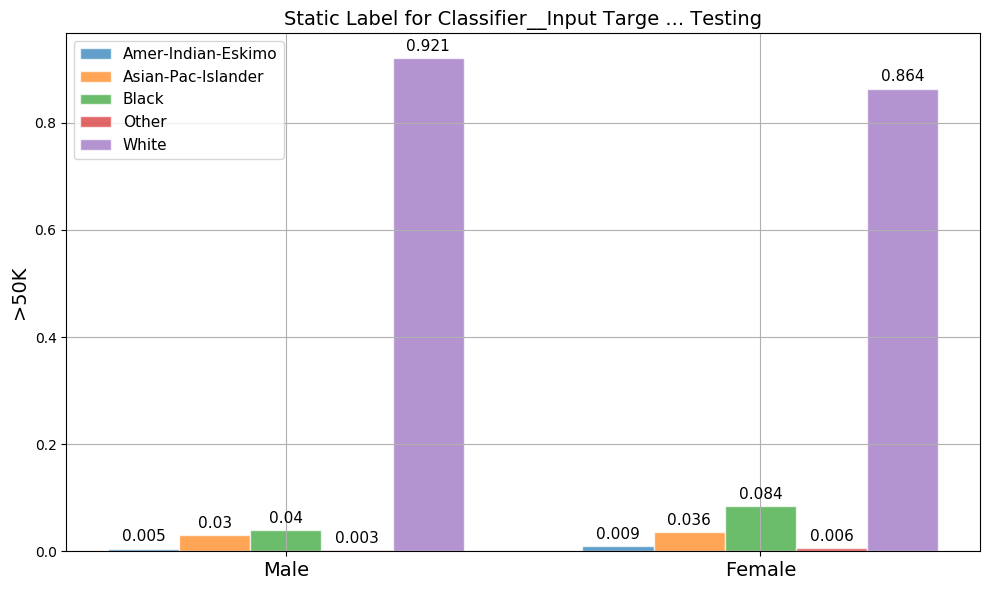

Negative_Lable:


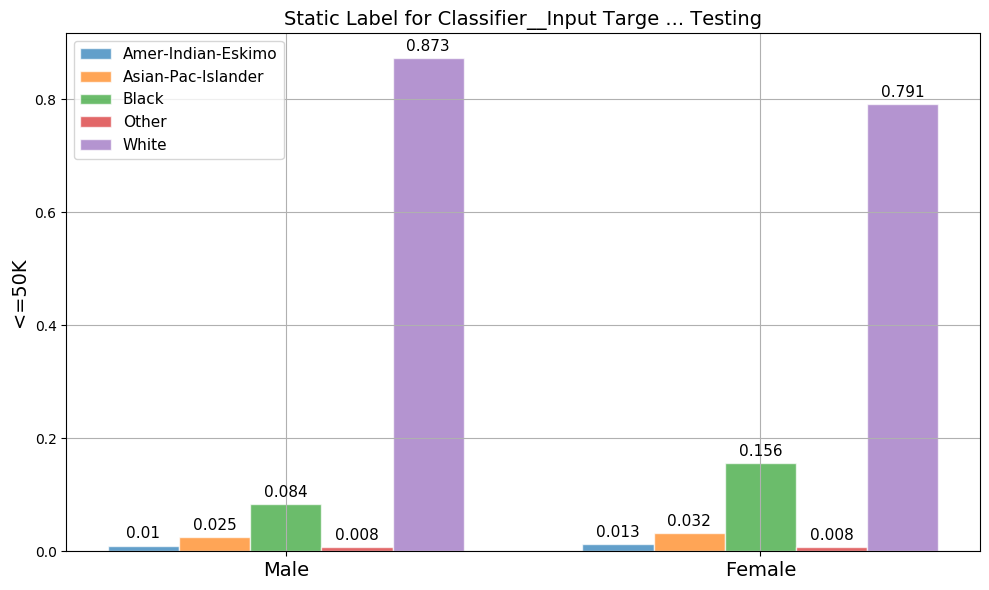

In [25]:
to_plot = static_label(target_df_test, snesi_atts, target_name)
plt_title = 'Static Label for Classifier__Input Target Column'

print("Positive_Lable:")
matplotlib_histogram(to_plot, plt_title, pos_group, show_pos = 1, suffix = ' Testing', export_images = True, save_path = save_path)
print("Negative_Lable:")
matplotlib_histogram(to_plot, plt_title, pos_group, show_pos = 0, suffix = ' Testing', export_images = True, save_path = save_path)

Positive_Lable:


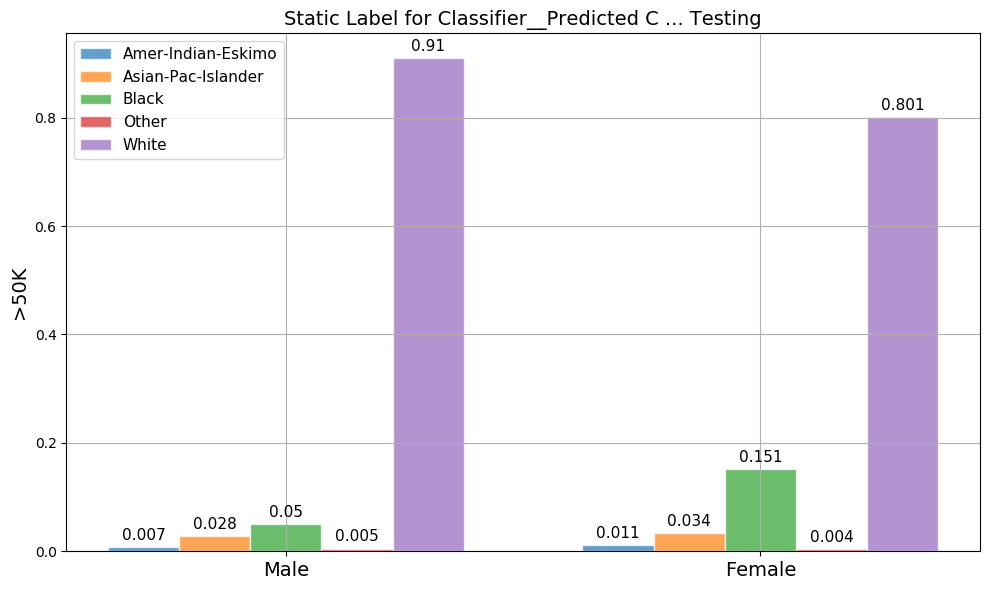

Negative_Lable:


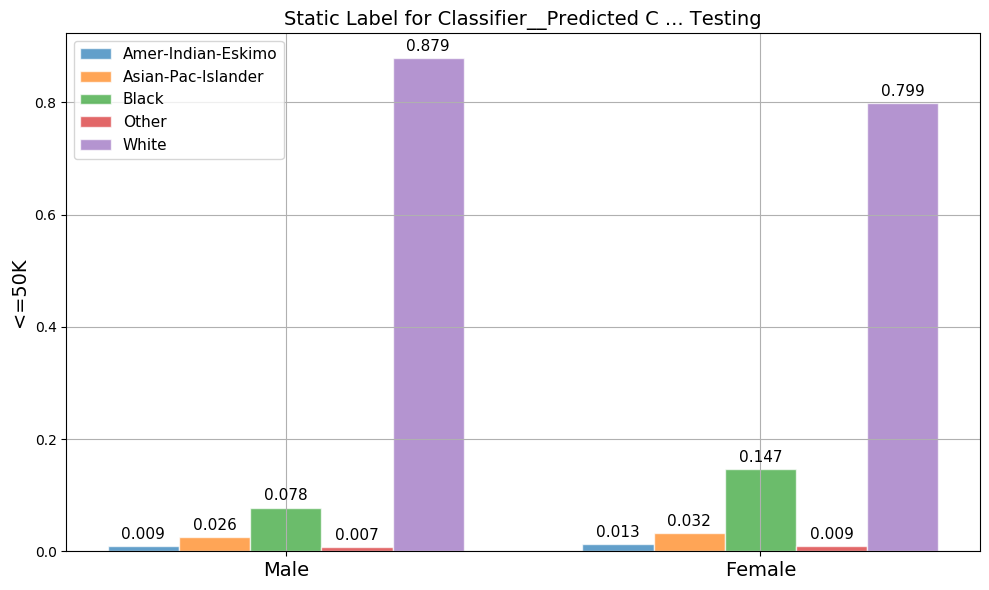

In [26]:
to_plot = static_label(target_df_test, snesi_atts, 'pred_'+target_name)
plt_title = 'Static Label for Classifier__Predicted Column'

print("Positive_Lable:")
matplotlib_histogram(to_plot, plt_title, pos_group, show_pos = 1, suffix = ' Testing', export_images = True, save_path = save_path)
print("Negative_Lable:")
matplotlib_histogram(to_plot, plt_title, pos_group, show_pos = 0, suffix = ' Testing', export_images = True, save_path = save_path)

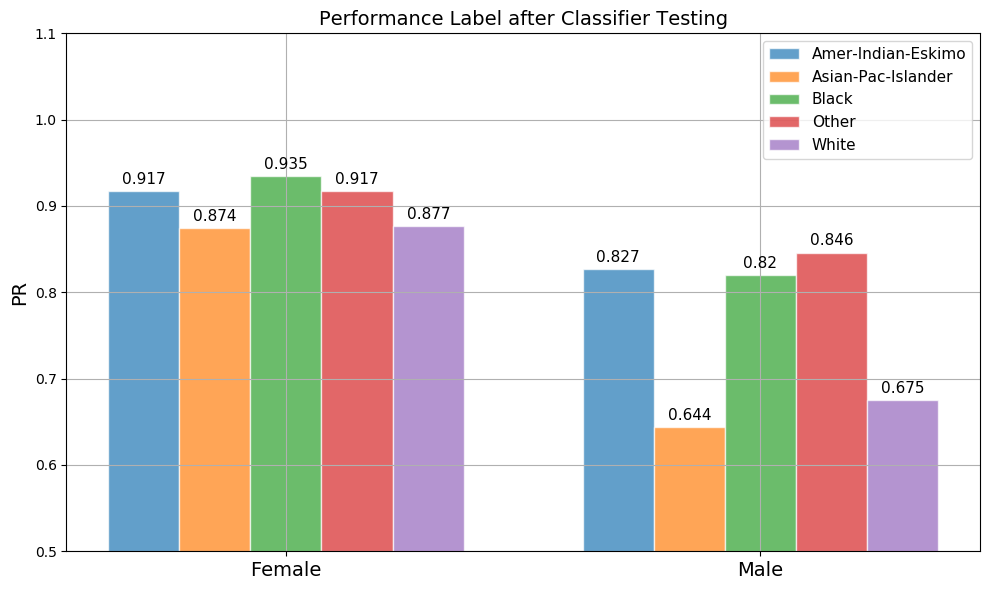

In [27]:

a = get_performance_label(target_df_test, snesi_atts, target_name, pos_group)

draw_bar_plot(a, "PR", snesi_atts, "Performance Label after Classifier Testing", False, True, save_path)